In [10]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sb
sb.set(style='white', context='notebook', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

import fitsio
from astropy.table import Table
from astropy.io import fits
from desitarget.sv3 import sv3_targetmask as targetmask
from desispec.io import specprod_root, read_spectra
from astropy.convolution import convolve, Gaussian1DKernel

In [11]:
# get list of secondary target observations 

fastfile = '/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/catalogs/fastspec-fuji.fits'
meta = Table(fitsio.read(fastfile, 'METADATA'))
strongLensTargs = meta[meta['SV3_SCND_TARGET'] & targetmask.scnd_mask['STRONG_LENS'] != 0]

In [12]:
strongLensTargs

TARGETID,SURVEY,PROGRAM,HEALPIX,TILEID_LIST,RA,DEC,COADD_FIBERSTATUS,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV1_SCND_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,Z,ZWARN,DELTACHI2,SPECTYPE,Z_RR,PHOTSYS,LS_ID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,EBV,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4
int64,str7,str6,int32,str47,float64,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,str6,float64,str1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1030495378866177,sv3,dark,26272,64,183.0992032053518,-1.5519835824353705,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,0,0,17179869184,0.9886868208465972,0,41.370555102825165,GALAXY,0.9886868208465972,S,9906620899002748,0.47704318,0.6450162,1.3858296,0.5075055,0.67248464,1.4185524,1.2384351,1.6410239,3.4616082,19.312368,14.830715,59.102585,4189.935,426.2214,261.88168,57.043575,1.6475109,0.44596,0.00041837306,8.161424e-06,0.020923926,0.9399764,0.9591538,0.9769323,0.9964603,0.99782467,0.9995357,0.99982464
1030495978651648,sv3,dark,25934,254,218.82868695999053,-1.4239743152821387,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,0,0,17179869184,0.7552786543004375,0,20.647511329501867,GALAXY,0.7552786543004375,S,9906620908373728,0.3527567,0.6940531,2.2230496,0.39786902,0.7526703,2.3262386,0.7178599,1.3580143,4.1971436,13.118159,7.1574516,-11.265225,221.51854,703.0262,166.76718,70.138176,2.8055162,0.67232096,0.0014525923,2.044261e-05,0.04067937,0.88661516,0.92212105,0.9556413,0.9931298,0.99577516,0.99909747,0.9996591
1030495978651649,sv3,dark,25934,469,218.82868695999053,-1.4239743152821387,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,0,0,17179869184,1.2252943755381192,0,192.01483857631683,GALAXY,1.2252943755381192,S,9906620908373728,0.3527567,0.6940531,2.2230496,0.39786902,0.7526703,2.3262386,0.7178599,1.3580143,4.1971436,13.118159,7.1574516,-11.265225,221.51854,703.0262,166.76718,70.138176,2.8055162,0.67232096,0.0014525923,2.044261e-05,0.04067937,0.88661516,0.92212105,0.9556413,0.9931298,0.99577516,0.99909747,0.9996591
1030507391352832,sv3,dark,25598,37,179.05473660408262,-1.0338561490522171,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,0,0,17179869184,0.42430836551677187,0,828.8541619591415,GALAXY,0.42430836551677187,S,9906621086696600,0.82633764,4.174602,10.330083,0.88873345,4.3844404,10.617518,4.096209,20.208067,48.93658,82.3844,48.75848,-13.012921,1354.9388,115.25883,41.92285,7.286568,0.99991137,0.27193624,0.0004319813,7.1654727e-06,0.024606165,0.9297924,0.9521402,0.97292817,0.99583864,0.99744236,0.99945396,0.99979377
1030507391352833,sv3,dark,25598,38,179.05530757612814,-1.0304179940984914,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,0,0,17179869184,1.4874464141342096,4,8.845336608588696,GALAXY,1.4874464141342096,S,9906621086696611,0.07715453,0.15995234,0.60885906,0.08302677,0.16805568,0.6259325,0.22725594,0.45999205,1.7132653,23.79166,25.288712,22.971962,-1266.7017,390.58636,165.20982,24.59277,1.9671621,0.4679887,0.000669508,9.107899e-06,0.024795065,0.92927295,0.9517818,0.9727232,0.9958068,0.99742275,0.9994498,0.9997922
1030507408130048,sv3,dark,25599,34,180.1889661147553,-0.9613644465384479,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,0,0,17179869184,0.6367214865921862,0,133.98583871871233,GALAXY,0.6367214865921862,S,9906621086961894,0.26557,0.8115323,2.7239323,0.2855533,0.8521845,2.7994688,0.52201

In [13]:
def plotDesiSpectra(coaddSpec, targetID, figpath, ax=None):
    '''
    coaddSpec [desispec] : desispec spectra object to plot
    '''
    
    if not ax:
        fig, ax = plt.subplots(figsize = (20, 6))
    
    # Plot the spectrum from each arm (B,R,Z) in blue, green, red
    ax.plot(coaddSpec.wave['b'], coaddSpec.flux['b'][0], color = 'b', alpha = 0.5)
    ax.plot(coaddSpec.wave['r'], coaddSpec.flux['r'][0], color = 'g', alpha = 0.5)
    ax.plot(coaddSpec.wave['z'], coaddSpec.flux['z'][0], color = 'r', alpha = 0.5)
    
    # Over-plotting smoothed spectra in black for all the three arms
    ax.plot(coaddSpec.wave['b'], convolve(coaddSpec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
    ax.plot(coaddSpec.wave['r'], convolve(coaddSpec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
    ax.plot(coaddSpec.wave['z'], convolve(coaddSpec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    
    fig.savefig(figpath, bbox_inches='tight', transparent=False)
    ax.clear()
    plt.close(fig)
    
def getCoadd(targetID, targetList=strongLensTargs):
    '''
    Get the coadded spectra for a given targetID from a given targetlist
    '''
    
    # define some directories
    specprod = 'fuji'    # Internal name for the EDR
    specprodDir = specprod_root(specprod)
    healpixDir = f'{specprodDir}/healpix'
    
    # select only one row of the strongLensTargs
    targ = targetList[targetList['TARGETID'] == targetID]
    survey = targ['SURVEY'][0]
    program = targ['PROGRAM'][0]
    hpx = targ['HEALPIX'][0]

    targDir = f'{healpixDir}/{survey}/{program}/{hpx//100}/{hpx}' # derive data directory holding spectra

    # get coadded spectra
    targCoaddFile = f'coadd-{survey}-{program}-{hpx}.fits'
    targCoadd = read_spectra(os.path.join(targDir, targCoaddFile))
    
    return targCoadd

In [14]:
## get spectra corresponding to strong lens targets
# first select a row in the strongLensTargs table to plot

overwrite = False

#idx = 100
#targetID = strongLensTargs[idx]['TARGETID']

for ii, targetID in enumerate(strongLensTargs['TARGETID']):
    
    figpath = f'KnownLensSpectra/LensSpec_ID{targetID}.jpeg'
    if os.path.exists(figpath) and not overwrite:
        print(f'{ii} : {figpath} already exists and overwrite is turned off')
        continue
    
    # get coadd corresponding to that targetID
    targCoadd = getCoadd(targetID)

    # plot them up
    plotDesiSpectra(targCoadd, targetID, figpath)

0 : KnownLensSpectra/LensSpec_ID1030495378866177.jpeg already exists and overwrite is turned off
1 : KnownLensSpectra/LensSpec_ID1030495978651648.jpeg already exists and overwrite is turned off
2 : KnownLensSpectra/LensSpec_ID1030495978651649.jpeg already exists and overwrite is turned off
3 : KnownLensSpectra/LensSpec_ID1030507391352832.jpeg already exists and overwrite is turned off
4 : KnownLensSpectra/LensSpec_ID1030507391352833.jpeg already exists and overwrite is turned off
5 : KnownLensSpectra/LensSpec_ID1030507408130048.jpeg already exists and overwrite is turned off
6 : KnownLensSpectra/LensSpec_ID1030507408130049.jpeg already exists and overwrite is turned off
7 : KnownLensSpectra/LensSpec_ID1030507957583872.jpeg already exists and overwrite is turned off
8 : KnownLensSpectra/LensSpec_ID1030513426956289.jpeg already exists and overwrite is turned off
9 : KnownLensSpectra/LensSpec_ID1030514068684801.jpeg already exists and overwrite is turned off
10 : KnownLensSpectra/LensSpec

Text(0.5, 0, 'Redrock Redshift of the Lens')

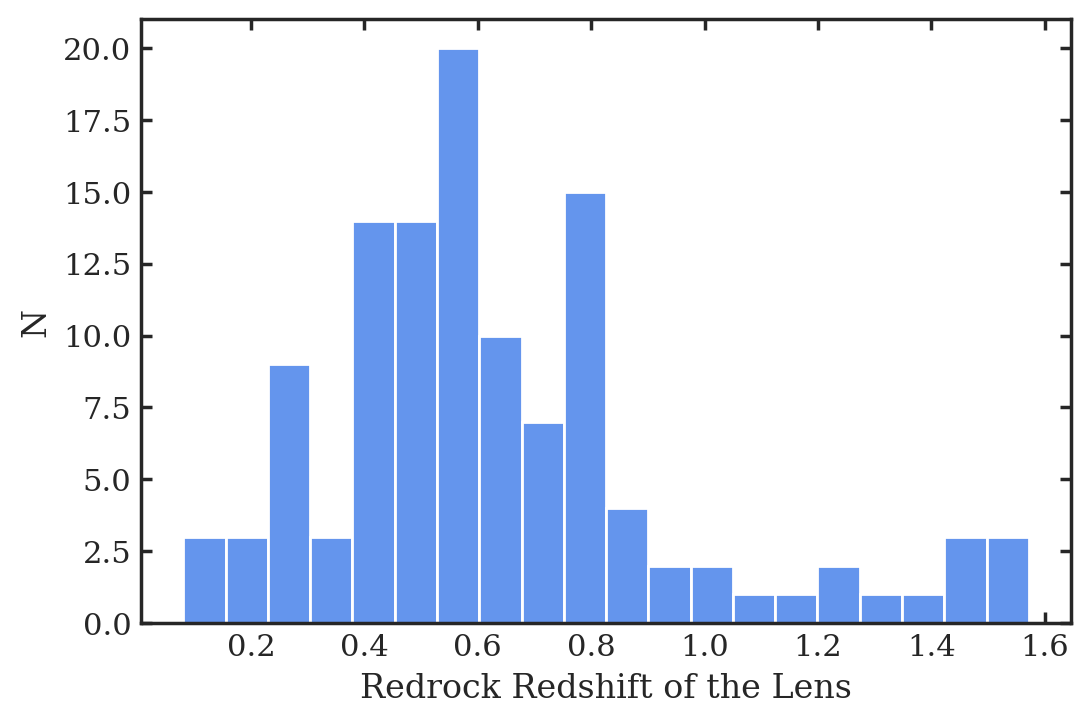

In [18]:
# histogram redshifts of known lenses
z = strongLensTargs['Z']

fig, ax = plt.subplots()

ax.hist(z, color='cornflowerblue', bins=20)
ax.set_ylabel('N')
ax.set_xlabel('Redrock Redshift of the Lens')

Text(0.5, 0, 'Delta Chi Squared')

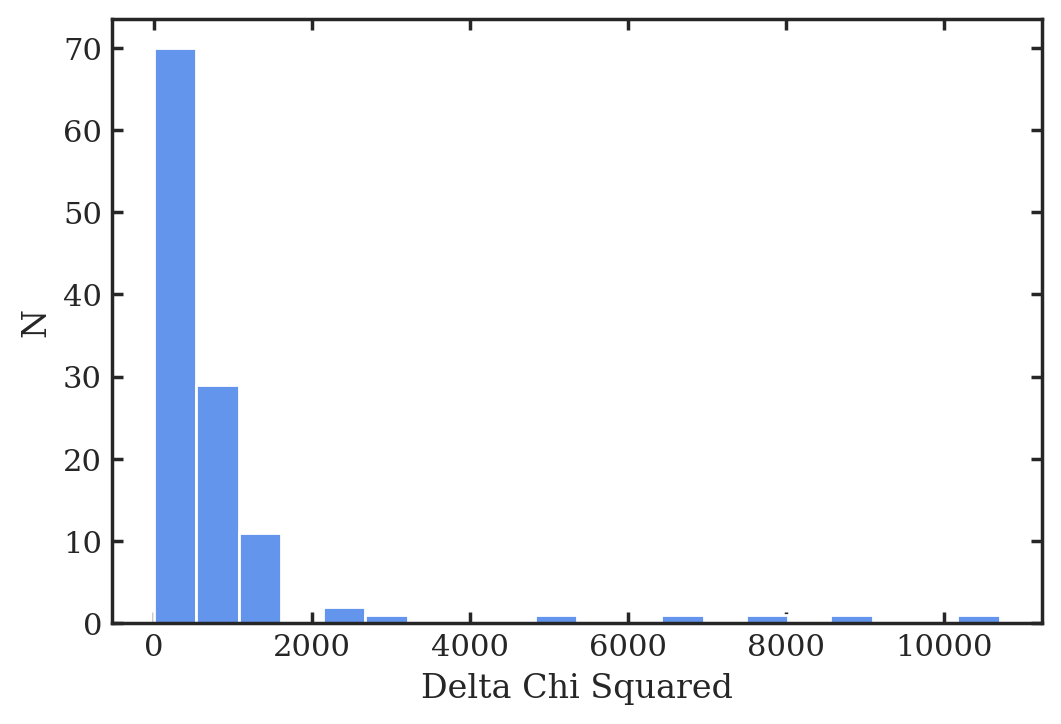

In [21]:
# histogram redshifts of known lenses
chi2 = strongLensTargs['DELTACHI2']

fig, ax = plt.subplots()

ax.hist(chi2, color='cornflowerblue', bins=20)
ax.set_ylabel('N')
ax.set_xlabel('Delta Chi Squared')